In [1]:
##ML / nerd shit import
import math
import matplotlib.pyplot as plt
import keras
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping

# Rael import
import datetime
import os
import urllib
import json
import yfinance as yf

In [2]:
#### READ THIS BEFORE CONTINUING ####

### CHANGE THE FOLLOWING VARIABLES ###
stock_name = "GOOGL" #--> GIVE THE TICKER NAME


### START AND END_DATES, GIVE YYYY-MM-DD format
start_date = "2023-05-06"

end_date = "2023-05-13"

### CHOOSE INTERVAL OF TRAINING DATA, BEWARNED THAT IF YOUR START AND END, LONG, MIGHT NOT BE ABLE TO GET LARGE INTERVAL 

time_interval = "1m" ## LIST OF HISTORY: [“1m”, “2m”, “5m”, “15m”, “30m”, “60m”, “90m”, “1h”, “1d”, “5d”, “1wk”, “1mo”, “3mo”]


start_date_2 = "2023-05-14"
end_date_2 = "2023-05-21"

In [3]:
#for saving / upadting / testing?
#need to change, then can run the above!
curr_day_to_string = datetime.date.today()
cache_fname = "/historical/" + f"{stock_name}_{curr_day_to_string}.csv"

stock = yf.Ticker(stock_name) #save the stock_name
## TO change the historical values, try to stick to 1m granularity
data = pd.DataFrame(stock.history(start=start_date, end=end_date, interval=time_interval))
data_2 = pd.DataFrame(stock.history(start=start_date_2, end=end_date_2, interval=time_interval))

data_combined = pd.concat((data, data_2), axis=0)
data_combined

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Datetime,,,,,,,
2023-05-08 09:30:00-04:00,105.180000,105.559998,105.160004,105.455002,733962,0.0,0.0
2023-05-08 09:31:00-04:00,105.440002,105.559998,105.360001,105.519997,65426,0.0,0.0
2023-05-08 09:32:00-04:00,105.534103,105.680000,105.457298,105.639999,104630,0.0,0.0
2023-05-08 09:33:00-04:00,105.660004,105.860001,105.650002,105.809898,95011,0.0,0.0
2023-05-08 09:34:00-04:00,105.779999,106.150002,105.779999,106.004997,111593,0.0,0.0
...,...,...,...,...,...,...,...
2023-05-19 15:55:00-04:00,122.709999,122.794998,122.680702,122.779999,195689,0.0,0.0
2023-05-19 15:56:00-04:00,122.779999,122.790001,122.680000,122.779999,176443,0.0,0.0
2023-05-19 15:57:00-04:00,122.790001,122.830002,122.760002,122.779999,250313,0.0,0.0


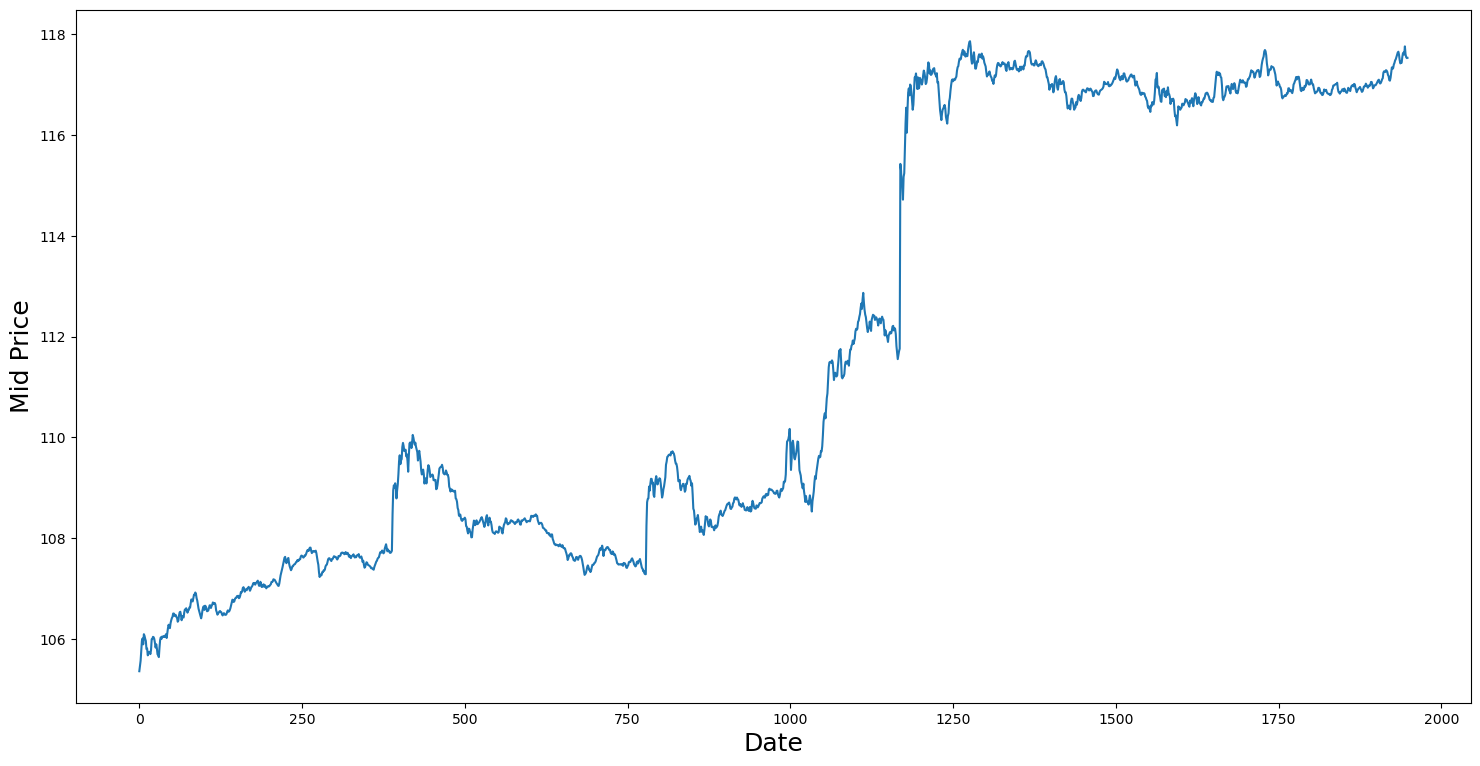

In [4]:
## NO CHANGES FROM HERE, JUST RUN EVERYTHING SEE NICE GRAPH


df = data.copy()
#df = df.rename(columns={'Datetime': 'Date'})
#visualization
plt.figure(figsize = (18,9))
plt.plot(range(df.shape[0]),(df['Low']+df['High'])/2.0) #we take an average
#plt.xticks(range(0,df.shape[0],500),df['Datetime'].loc[::500],rotation=45)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Mid Price',fontsize=18)
plt.show()

In [5]:
#let's try to predict the last 100% of values (this is arbitrary)
#default [1:3] = high + low
length = len(df)
train_len = math.ceil(1.0 * length)
print(train_len)
training_set = df.iloc[:train_len, 1:2].values
#print(training_set)
test_set = df.iloc[train_len:, 1:2].values #take the last x values? (to predict!)
print(test_set.shape)

1949
(0, 1)


In [6]:
sc = MinMaxScaler(feature_range = (0, 1)) #-->every scaled btwn 0-1, helps with variance
training_set_scaled = sc.fit_transform(training_set)
# Creating a data structure with 60 time-steps and 1 output
X_train = []
y_train = []
for i in range(60, train_len-60):
    X_train.append(training_set_scaled[i-60:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
print(X_train.shape)

(1829, 60, 1)


In [7]:
##TODO: Maybe tune the model such that LSTM units are changed?
model = Sequential()
#Adding the first LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
model.add(Dropout(0.2))
# Adding a second LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))
# Adding a third LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))
# Adding a fourth LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50))
model.add(Dropout(0.2))
# Adding the output layer
model.add(Dense(units = 1))

# Compiling the RNN
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

model.fit(X_train, y_train, epochs = 100, batch_size = 256)

Epoch 1/100
8/8 [==============================] - 6s 168ms/step - loss: 0.1432
Epoch 2/100
8/8 [==============================] - 1s 175ms/step - loss: 0.0291
Epoch 3/100
8/8 [==============================] - 1s 171ms/step - loss: 0.0148
Epoch 4/100
8/8 [==============================] - 1s 171ms/step - loss: 0.0096
Epoch 5/100
8/8 [==============================] - 1s 174ms/step - loss: 0.0077
Epoch 6/100
8/8 [==============================] - 1s 172ms/step - loss: 0.0071
Epoch 7/100
8/8 [==============================] - 1s 173ms/step - loss: 0.0064
Epoch 8/100
8/8 [==============================] - 1s 176ms/step - loss: 0.0061
Epoch 9/100
8/8 [==============================] - 1s 171ms/step - loss: 0.0059
Epoch 10/100
8/8 [==============================] - 1s 178ms/step - loss: 0.0058
Epoch 11/100
8/8 [==============================] - 1s 177ms/step - loss: 0.0058
Epoch 12/100
8/8 [==============================] - 1s 179ms/step - loss: 0.0054
Epoch 13/100
8/8 [===================

In [8]:
###TO DO PREDICTION

### START AND END_DATES, GIVE YYYY-MM-DD format
start_date_p = "2023-05-22"

end_date_p = "2023-05-28"

### CHOOSE INTERVAL OF TRAINING DATA, BEWARNED THAT IF YOUR START AND END, LONG, MIGHT NOT BE ABLE TO GET LARGE INTERVAL 

time_interval_p = "1m" ## LIST OF HISTORY: [“1m”, “2m”, “5m”, “15m”, “30m”, “60m”,


data_p = pd.DataFrame(stock.history(start=start_date_p, end=end_date_p, interval=time_interval))
df_p = data_p.copy()
train_len_p = math.ceil(len(df_p) * 0.8)

print(train_len_p)
print(df_p)

1560
                                 Open        High         Low       Close  \
Datetime                                                                    
2023-05-22 09:30:00-04:00  122.940002  124.279999  122.739998  124.199997   
2023-05-22 09:31:00-04:00  124.209999  124.320000  123.889999  124.275002   
2023-05-22 09:32:00-04:00  124.269997  124.459999  124.150002  124.330002   
2023-05-22 09:33:00-04:00  124.339996  124.769997  124.339996  124.730301   
2023-05-22 09:34:00-04:00  124.730003  124.849998  124.552002  124.830002   
...                               ...         ...         ...         ...   
2023-05-26 15:55:00-04:00  124.739998  124.845001  124.735001  124.839996   
2023-05-26 15:56:00-04:00  124.839996  124.849998  124.660004  124.699997   
2023-05-26 15:57:00-04:00  124.705002  124.709999  124.574997  124.643799   
2023-05-26 15:58:00-04:00  124.639999  124.660004  124.589996  124.599998   
2023-05-26 15:59:00-04:00  124.595001  124.639999  124.519997  124.5999

In [18]:
dataset_train = df_p.iloc[:train_len_p, 1:2]
print(len(dataset_train))
dataset_test = df_p.iloc[train_len_p:, 1:2]

dataset_total = pd.concat((dataset_train, dataset_test), axis = 0)


print(dataset_total.shape)


inputs = dataset_total[len(dataset_total) - len(dataset_test) - 60:].values
inputs = inputs.reshape(-1,1)
print(inputs.shape)
inputs = sc.transform(inputs)
X_test = []
for i in range(60, train_len_p):
    temp = inputs[i-60:i, 0]
    if len(temp) != 60:
        break
    X_test.append(temp)
X_test = np.array(X_test, dtype=np.float32)
print(X_test.shape)
X_test = X_test.reshape((X_test.shape[0], -1))
#reshape into 3D model for LSTM 
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1)) 

1560
(1949, 1)
(449, 1)
(390, 60)


In [10]:
predicted_stock_price = model.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)
print(len(predicted_stock_price))

13/13 [==============================] - 1s 16ms/step
391


(391, 1)


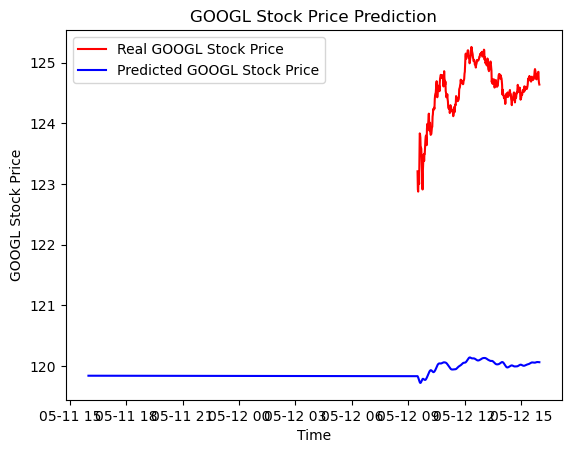

In [17]:
## to check prediction 
df_p =df.reset_index() #--> get rid of datetime as default index
plt.plot(df_p.loc[train_len_p - 1:, "Datetime"],dataset_test.values, color = "red", label = f'Real {stock_name} Stock Price')
print(predicted_stock_price.shape)
plt.plot(df_p.loc[train_len_p - 2:, "Datetime"],predicted_stock_price, color = "blue", label = f'Predicted {stock_name} Stock Price')
#plt.xticks(np.arange(118,1)) #this is just to clear the x-axis
plt.title(f'{stock_name} Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel(f'{stock_name} Stock Price')
plt.legend()
plt.show()